In [1]:
### Classify cats or dogs images.

# 1/ Build data input pipeline (ImageDataGenerator -> Generate batches of tensor image data with real-time data augmentation) 
# 2/ Overfitting
# 3/ Data augmentation and Dropout

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Import TF and specific modules from Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-rc0


In [3]:
### Load the data (similar to Kaggle version)

URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# Download the data from the URL
dataset_zip_path = tf.keras.utils.get_file('cats_and_dogs.zip', origin = URL, extract = True)

# Concatenate the name of the folder with the name of the file
PATH = os.path.join(os.path.dirname(dataset_zip_path), 'cats_and_dogs_filtered')
print('PATH', PATH)

# cats_and_dogs_filtered/
# -- train
# ---- cats: [cat.0.jpg, cat.1.jpg, ...]
# ---- dogs: [dog.0.jpg, dog.1.jpg, ...]
# -- validation
# ---- cats: [cat.2000.jpg, cat.2001.jpg, ...]
# ---- dogs: [dog.2000.jpg, dog.2001.jpg, ...]

PATH /Users/nicolas/.keras/datasets/cats_and_dogs_filtered


In [4]:
# Get the path of the training and validation/dev sets

# Directiories
training_directory = os.path.join(PATH, 'train')
validation_directory = os.path.join(PATH, 'validation')

# Cats/Dogs directories
training_cats_directory = os.path.join(training_directory, 'cats')
training_dogs_directory = os.path.join(training_directory, 'dogs')

validation_cats_directory = os.path.join(validation_directory, 'cats')
validation_dogs_directory = os.path.join(validation_directory, 'dogs')

In [5]:
# Explore the data

size_training_cats = len(os.listdir(training_cats_directory))
size_training_dogs = len(os.listdir(training_dogs_directory))

size_validation_cats = len(os.listdir(validation_cats_directory))
size_validation_dogs = len(os.listdir(validation_dogs_directory))

print('TRAINING SET:')
print('NUMBER OF CATS IMAGES: ', size_training_cats)
print('NUMBER OF DOGS IMAGES: ', size_training_dogs)
print('-'*30)
print('VALIDATION SET:')
print('NUMBER OF CATS IMAGES: ', size_validation_cats)
print('NUMBER OF DOGS IMAGES: ', size_validation_dogs)

TRAINING SET:
NUMBER OF CATS IMAGES:  1000
NUMBER OF DOGS IMAGES:  1000
------------------------------
VALIDATION SET:
NUMBER OF CATS IMAGES:  500
NUMBER OF DOGS IMAGES:  500


In [6]:
# Set-up variable we'll use throughout the notebook

BATCH_SIZE = 128
EPOCHS = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [7]:
### Data preparation
# 1/ Read the images from the disk
# 2/ Decode contents and convert them into proper grid format
# 3/ Convert them into floating point tensors
# 4/ Data normalization (NN prefers to deal with small input value)

#-> Use ImageDataGenerator

In [8]:
# Here we use ImageDataGenerator only to rescale the image,
# but we can also use it to increase the size of the dataset with rotation, translation...

train_images_generator = ImageDataGenerator(rescale = 1./255) # Generator for the training set
validation_images_generator = ImageDataGenerator(rescale = 1./255) # Generator for the validation set

In [9]:
# Use the flow_from_directory method to:
# 1/ Load from disk (.jpg)
# 2/ Rescale images
# 3/ Resize images

# flow_from_directory -> Takes the path to a directory & generates batches of augmented data.
train_data = train_images_generator.flow_from_directory(batch_size = BATCH_SIZE,
                                                        directory = training_directory, # path to the target directory. It should contain one subdirectory per class
                                                        shuffle = True,
                                                        target_size = (IMG_HEIGHT, IMG_WIDTH), # Resize
                                                        class_mode = 'binary')

print('1st batch shape(example): ', next(train_data)[0].shape)
print('1st batch shape(label): ', next(train_data)[1].shape)

validation_data = train_images_generator.flow_from_directory(batch_size = BATCH_SIZE,
                                                        directory = training_directory, # path to the target directory. It should contain one subdirectory per class
                                                        shuffle = True,
                                                        target_size = (IMG_HEIGHT, IMG_WIDTH), # Resize
                                                        class_mode = 'binary')

# From the .jpg images, we now have generators of batch of images represented as numpy arrays

Found 2000 images belonging to 2 classes.
1st batch shape(example):  (128, 150, 150, 3)
1st batch shape(label):  (128,)
Found 2000 images belonging to 2 classes.


In [10]:
# Visualize the training images

# Get the first batch of images
sample_training_images, _ = next(train_data) # Get a batch. It is a tuple (x_train, y_train) where x is (batch, size, n_h, n_w, n_c)


In [11]:
# Define a function to plot the images
def plotImages(images):
    ''' Plot the first 5 images of the batch of images given
    '''
    # CAREFUL plt.subplots =/= plt.subplot
    fig, axes = plt.subplots(1, 5, figsize = (20, 20)) # (Number of rows/columns of the subplot grid)
    # Flatten the axes to loop over them
    axes = axes.flatten()
    for image, ax in zip(images, axes):
        ax.imshow(image)
        ax.axis('off')
    plt.tight_layout() # Automatically adjust subplot parameters to give specified padding.
    plt.show()

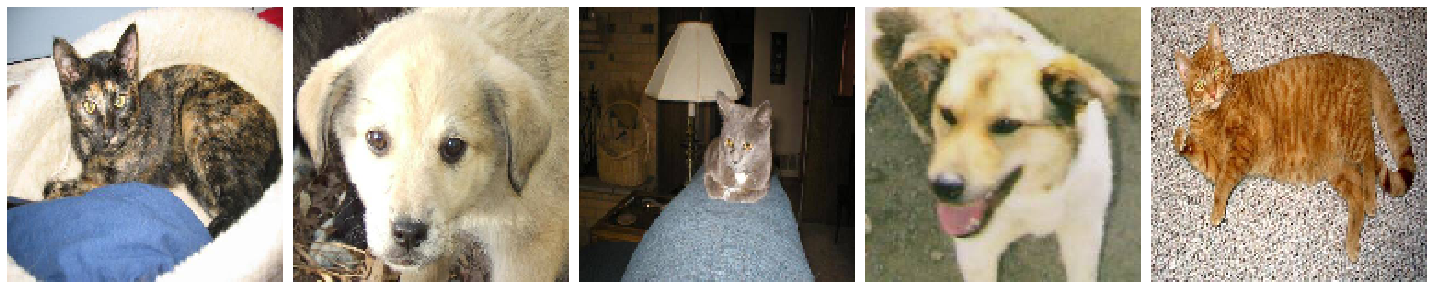

In [12]:
# Plot the first 5 images of the training set
plotImages(sample_training_images[:5])

In [13]:
### Create a model

# CONV(3 x 3 x 3 x 16) -> Relu -> MAXPOOLING(2 x 2) -> CONV(3 x 3 x 16 x 32) -> Relu -> MAXPOOLING  ->
# CONV(3 x 3 x 32 x 64) -> Relu -> FLATTEN -> FC(512) -> Relu -> FC(1) -> Sigmoid

model = Sequential([Conv2D(16, 3, padding = 'same', activation = 'relu', input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)),
                    MaxPooling2D(),
                    Conv2D(32, 3, padding = 'same', activation = 'relu'),
                    MaxPooling2D(),
                    Conv2D(64, 3, padding = 'same', activation = 'relu'),
                    MaxPooling2D(),
                    Flatten(),
                    Dense(512, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
                ])

In [14]:
### Add the optimizer, loss and metrics

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [16]:
### Train the model

# Trains the model on data generated batch-by-batch by a Python generator

# Set the steps per epoch not to high, otherwise it takes too much time
history = model.fit_generator(train_data,
                              steps_per_epoch = 50, # size_training_cats + size_training_dogs,
                              epochs = EPOCHS,
                              validation_data = validation_data,
                              validation_steps = 50) #size_validation_cats + size_validation_dogs)

Epoch 1/15


W0914 11:38:42.538928 140736140276608 deprecation.py:323] From /Users/nicolas/anaconda/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1394: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


50/50 [==============================] - 198s 4s/step - loss: 0.7947 - accuracy: 0.5699 - val_loss: 0.5918 - val_accuracy: 0.6894

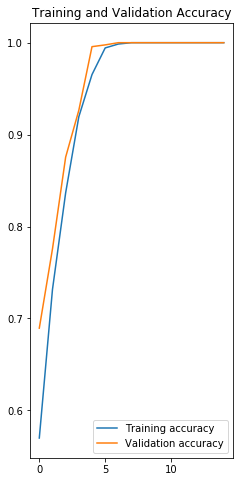

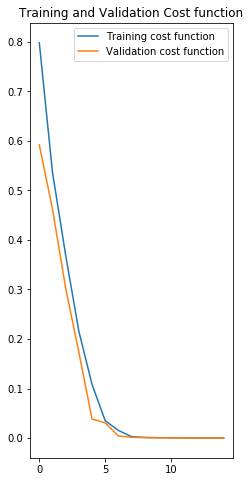

In [17]:
### Let's visualize the accuracy and the cost function as a function of the epoch number

# Accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(EPOCHS)

# Accuracy plot
# Define a figure size as well as its 2 suplots
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, train_acc, label = 'Training accuracy')
plt.plot(epoch_range, val_acc, label = 'Validation accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

# Cost function plot
# Define a figure size as well as its 2 suplots
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 2)
plt.plot(epoch_range, train_loss, label = 'Training cost function')
plt.plot(epoch_range, val_loss, label = 'Validation cost function')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Cost function')

plt.show()


In [18]:
### Deal with overfitting
# 1/ Data augmentation -> Generate more training examples from existing training examples

# Apply random horizontal flip using ImageDataGenerator

generator_flip = ImageDataGenerator(rescale = 1./255,
                                          horizontal_flip = True) # Randomly flip inputs horizontally.

# Takes the path to a directory & generates batches of augmented data.
train_generator_flip = generator_flip.flow_from_directory(batch_size = BATCH_SIZE,
                                                          directory = training_directory,
                                                          shuffle = True,
                                                          target_size = (IMG_HEIGHT, IMG_WIDTH))

print('Shape of the first batch(example): ', next(train_generator_flip)[0].shape)
print('Shape of the first batch(target): ', next(train_generator_flip)[1].shape)

Found 2000 images belonging to 2 classes.
Shape of the first batch(example):  (128, 150, 150, 3)
Shape of the first batch(target):  (128, 2)


(150, 150, 3)


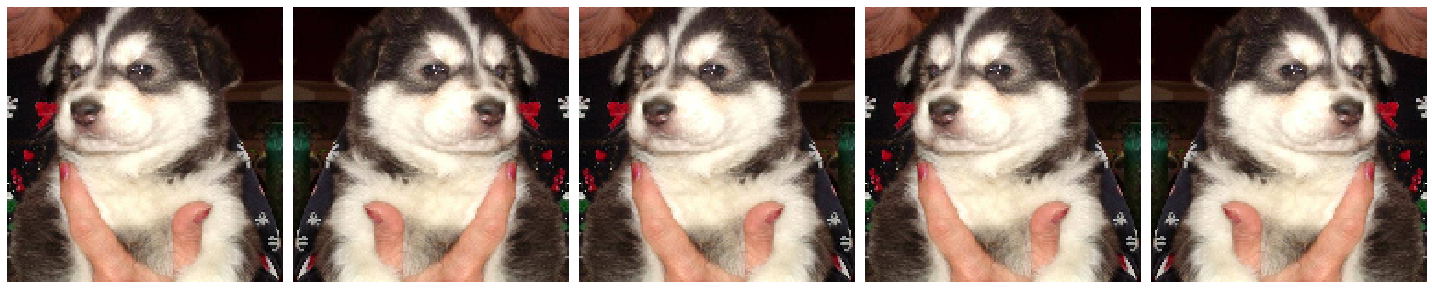

In [19]:
# Let's visualize the transformation
# Example -> Batch Number -> Image number
print(train_generator_flip[0][0][0].shape)

augmented_images = [train_generator_flip[0][0][0] for i in range(5)]
# Plot them
plotImages(augmented_images)

# When a specific image is called from the generator, the 'random transformation' is applied. 
# Thus, there is no deterministic way to call an image

Found 2000 images belonging to 2 classes.


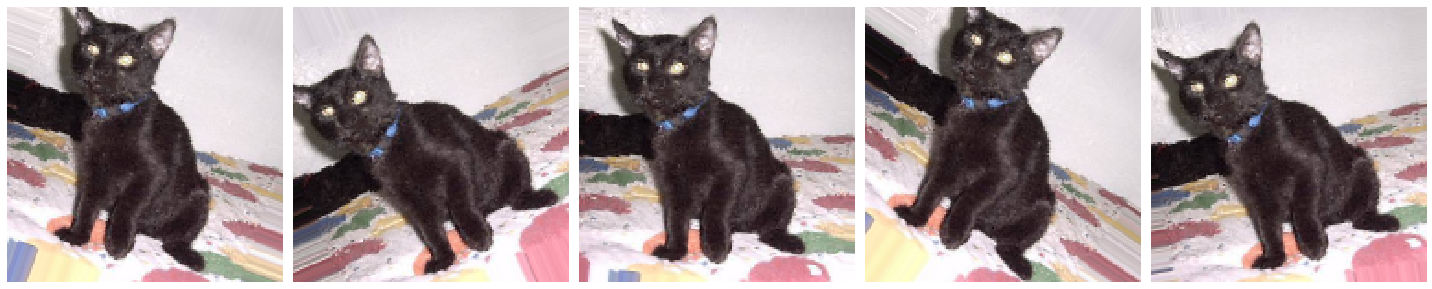

In [20]:
# Apply a random rotation of 45 degree

generator_rotation = ImageDataGenerator(rescale = 1./255,
                                        rotation_range = 45)

# Takes the path to a directory & generates batches of augmented data.
train_generator_rotation = generator_rotation.flow_from_directory(batch_size = BATCH_SIZE,
                                                                  directory = training_directory,
                                                                  shuffle = True,
                                                                  target_size = (IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_generator_rotation[0][0][0] for i in range(5)]
# Plot them
plotImages(augmented_images)

Found 2000 images belonging to 2 classes.


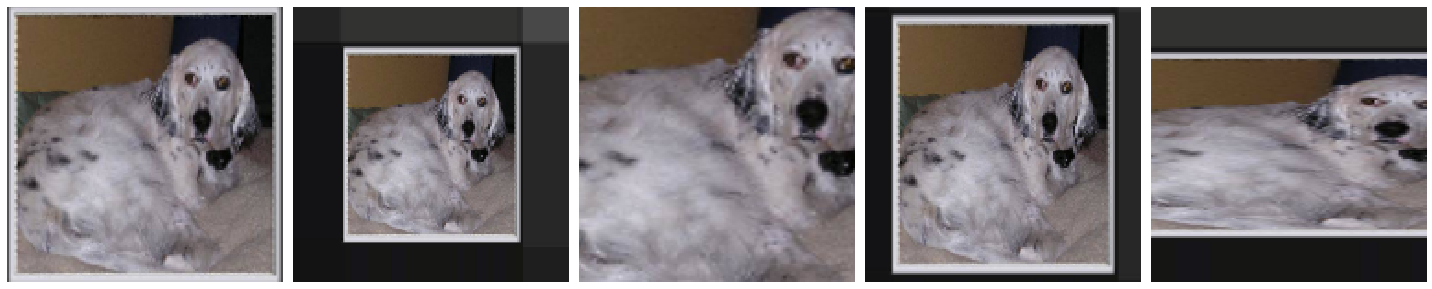

In [21]:
# Apply a zoom augmentation

generator_zoom = ImageDataGenerator(rescale = 1./255,
                                    zoom_range = 0.5)

# Takes the path to a directory & generates batches of augmented data.
train_generator_zoom = generator_zoom.flow_from_directory(batch_size = BATCH_SIZE,
                                                          directory = training_directory,
                                                          shuffle = True,
                                                          target_size = (IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_generator_zoom[0][0][0] for i in range(5)]
# Plot them
plotImages(augmented_images)

Found 2000 images belonging to 2 classes.
<class 'tuple'>


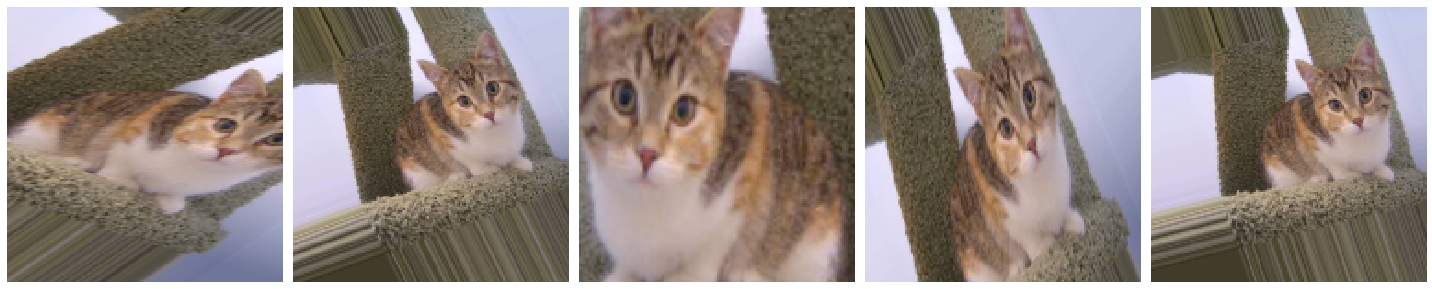

In [22]:
# Apply all the previous augmentation together

generator = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 45,
                               width_shift_range = 0.15,
                               height_shift_range = 0.15,
                               horizontal_flip = True,
                               zoom_range = 0.5)

# Takes the path to a directory & generates batches of augmented data.
train_generator = generator.flow_from_directory(batch_size = BATCH_SIZE,
                                              directory = training_directory,
                                              shuffle = True,
                                              target_size = (IMG_HEIGHT, IMG_WIDTH),
                                              class_mode = 'binary') # Mode for yielding the targets: 1D numpy array of binary labels
print(type(train_generator[0]))

augmented_images = [train_generator[0][0][0] for i in range(5)]
# Plot them
plotImages(augmented_images)

In [23]:
# Generally, only apply data augmentation to the TRAINING example.
# We'll just create a ImageDataGenerator for the validation set in order to rescale the images 
# and convert them into batches

generator_val = ImageDataGenerator(rescale = 1./255)

# Takes the path to a directory & generates batches of augmented data.
val_generator = generator_val.flow_from_directory(batch_size = BATCH_SIZE,
                                              directory = validation_directory,
                                              target_size = (IMG_HEIGHT, IMG_WIDTH),
                                              class_mode = 'binary') # Mode for yielding the targets: 1D numpy array of binary labels



Found 1000 images belonging to 2 classes.


In [24]:
# Note that ImageDataGenerator won't increase the training set. Instead, it will apply a random transformation to
# an image when it is called. Thus it initially we had 2000 images in your training set, you'll still have 2000 images.
# However, each of these images may be different when called, at each epoch !

In [25]:
# Dropout

model_dropout = Sequential([Conv2D(16, 3, padding = 'same', activation = 'relu', input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)),
                    MaxPooling2D(),
                    Dropout(0.2), # Different neurons droped for each Training example
                    Conv2D(32, 3, padding = 'same', activation = 'relu'),
                    MaxPooling2D(),
                    Conv2D(64, 3, padding = 'same', activation = 'relu'),
                    MaxPooling2D(),
                    Dropout(0.2), 
                    Flatten(),
                    Dense(512, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
                ])

In [26]:
### Add the optimizer, loss and metrics

model_dropout.compile(optimizer = 'adam',
                      loss = 'binary_crossentropy',
                      metrics = ['accuracy'])

In [27]:
model_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

In [28]:
### Train the model

# Trains the model on data generated batch-by-batch by a Python generator

# Set the steps per epoch not to high, otherwise it takes too much time
history = model.fit_generator(train_generator, # Augmented training set
                              steps_per_epoch = 50, # size_training_cats + size_training_dogs,
                              epochs = EPOCHS,
                              validation_data = val_generator,
                              validation_steps = 50) #size_validation_cats + size_validation_dogs)

Epoch 1/15
50/50 [==============================] - 215s 4s/step - loss: 0.8594 - accuracy: 0.5305 - val_loss: 0.6836 - val_accuracy: 0.5432

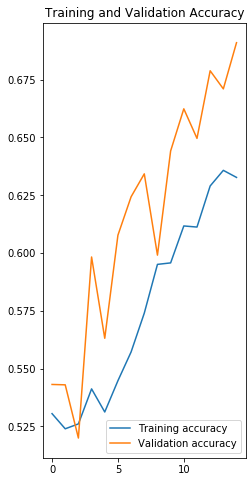

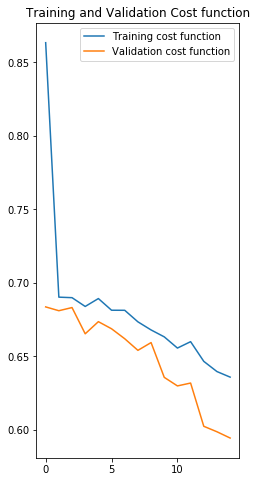

In [29]:
### Let's visualize the accuracy and the cost function as a function of the epoch number (WITH DROPOUT)

# Accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(EPOCHS)

# Accuracy plot
# Define a figure size as well as its 2 suplots
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, train_acc, label = 'Training accuracy')
plt.plot(epoch_range, val_acc, label = 'Validation accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

# Cost function plot
# Define a figure size as well as its 2 suplots
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 2)
plt.plot(epoch_range, train_loss, label = 'Training cost function')
plt.plot(epoch_range, val_loss, label = 'Validation cost function')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Cost function')

plt.show()
